In [2]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
results = pd.read_csv("../src/output/aura_output_1.csv", delimiter=";")

In [4]:
results

,Dataset,Classifier,Fit time,Test accuracy,Train accuracy
0,adult,Nearest Neighbors,0.3414,0.7747,0.8329
1,adult,Linear SVM,600.0000,0.0000,0.0000
2,adult,RBF SVM,600.0000,0.0000,0.0000
3,adult,Gaussian Process,600.0000,0.0000,0.0000
4,adult,Decision Tree,0.3127,0.8093,0.9998
5,adult,Random Forest,16.6492,0.8525,0.9998
6,adult,Neural Net,25.7229,0.6795,0.6782
7,adult,AdaBoost,7.1172,0.8600,0.8606
8,adult,Naive Bayes,0.1871,0.7950,0.7948
9,adult,QDA,0.2743,0.8036,0.8037


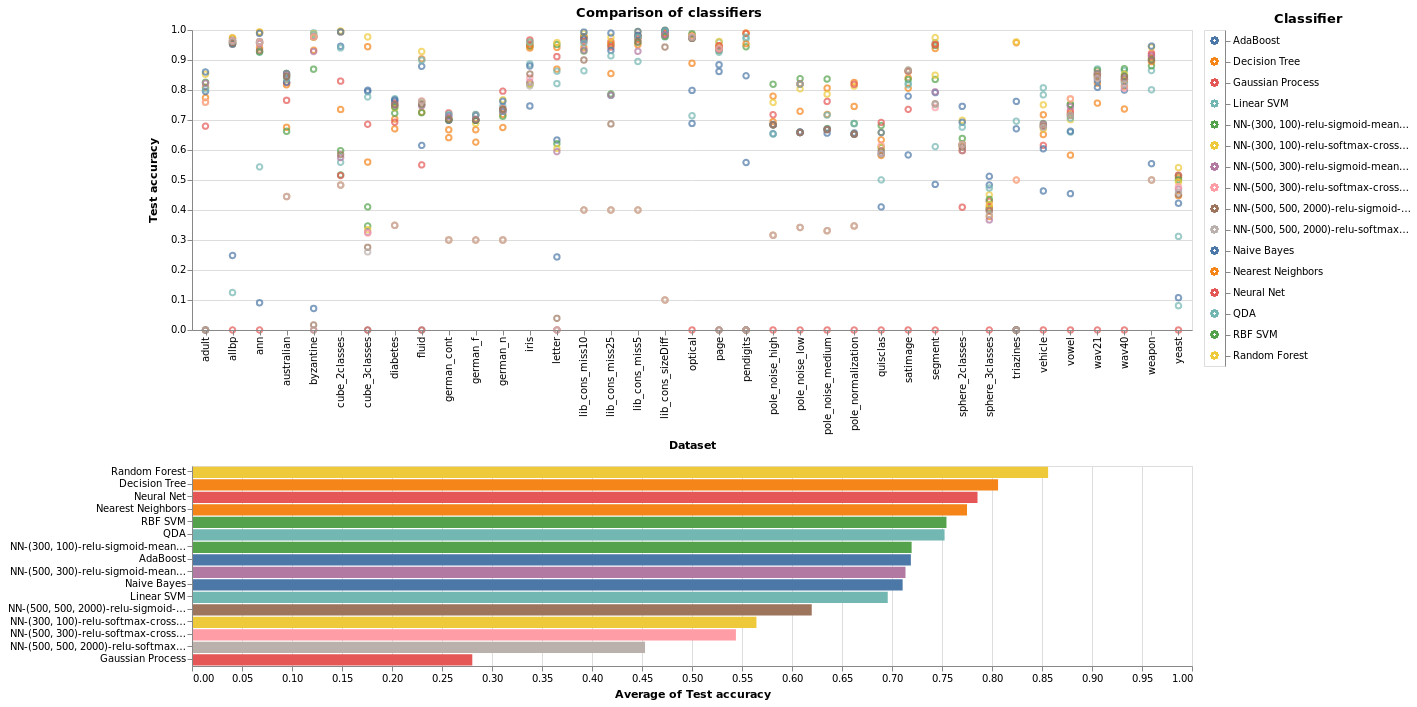

In [5]:
selection = alt.selection_multi(fields=["Classifier"])
brush = alt.selection(type="interval")

predicate = selection | brush

color = alt.condition(
    predicate, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
)


points = (
    alt.Chart()
    .mark_point()
    .encode(
        x=alt.X("Dataset"),
        y=alt.Y("Test accuracy:Q", scale=alt.Scale(domain=(0, 1))),
        color=alt.condition(
            predicate, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
        ),
        tooltip=[
            "Classifier:N",
            alt.Text("Test accuracy:Q", title="Accuracy", format=".3f"),
            "Dataset:N",
        ],
    )
    .add_selection(brush, selection)
    .properties(width=1000, height=300, title="Comparison of classifiers")
)

legend = (
    alt.Chart()
    .mark_point()
    .encode(
        y=alt.Y("Classifier:N", axis=alt.Axis(orient="right"), title=""),
        color=alt.condition(
            selection, alt.Color("Classifier:N", legend=None), alt.value("lightgray")
        ),
    )
    .add_selection(selection)
    .properties(title="Classifier")
)

bars = (
    alt.Chart()
    .mark_bar()
    .encode(
        y=alt.Y(
            "Classifier:N",
            sort=alt.EncodingSortField(
                field="Test accuracy", op="mean", order="descending"
            ),
            title="",
        ),
        color=alt.Color("Classifier:N", legend=None),
        tooltip=[
            "Classifier:N",
            alt.Text("average(Test accuracy):Q", title="Average accuracy", format=".3f"),
        ],
        x=alt.X("average(Test accuracy):Q", scale=alt.Scale(domain=(0, 1))),
    )
    .transform_filter(predicate)
    .properties(width=1000, height=200)
)

chart = alt.vconcat(alt.hconcat(points, legend, data=results), bars, data=results)

chart

In [6]:
chart.save("results.html")

# Wilcoxon

In [13]:
from scipy.stats import wilcoxon
from itertools import product

In [45]:
classifiers = results['Classifier'].unique()
datasets = results['Dataset'].unique()

reshaped = results.pivot(index='Classifier',
                         columns='Dataset',
                         values='Test accuracy')
wilcoxon_res = pd.DataFrame(columns=classifiers, index=classifiers)

for clf_a, clf_b in product(classifiers, repeat=2):
    if clf_a == clf_b:
        continue
        
    a = reshaped.loc[clf_a].values
    b = reshaped.loc[clf_b].values
    
    z_stat, p_val = wilcoxon(a,b)
    wilcoxon_res.at[clf_a, clf_b] = p_val
    
wilcoxon_res.fillna(0, inplace=True)
wilcoxon_res.to_csv('wilcoxon.csv')            